In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Video_games_5.csv"
df = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluación de los datos

In [ ]:
df.head()

,reviewText,overall,asin,reviewTime,cleaned_reviewText,entities
0,"This game is a bit hard to get the hang of, bu...",5.0,0700026657,2015-10-17,game bit hard hang great,[]
1,I played it a while but it was alright. The st...,4.0,0700026657,2015-07-27,play alright steam bit trouble game steam hard...,"[('steam', 'PLATFORM'), ('2205', 'DATE')]"
2,ok game.,3.0,0700026657,2015-02-23,ok game,[]
3,"found the game a bit too complicated, not what...",2.0,0700026657,2015-02-20,find game bit complicated expect having play 1...,"[('1602, 1503', 'DATE'), ('1701', 'DATE')]"
4,"great game, I love it and have played it since...",5.0,0700026657,2014-12-25,great game love play arrive,[]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497061 entries, 0 to 497060
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewText          497061 non-null  object 
 1   overall             497061 non-null  float64
 2   asin                497061 non-null  object 
 3   reviewTime          497061 non-null  object 
 4   cleaned_reviewText  496258 non-null  object 
 5   entities            497061 non-null  object 
dtypes: float64(1), object(5)
memory usage: 22.8+ MB


In [ ]:
df.isna().sum()

reviewText              0
overall                 0
asin                    0
reviewTime              0
cleaned_reviewText    803
entities                0
dtype: int64

In [ ]:
asin_counts = df['asin'].value_counts()

# Obtener el top 5 de ASIN más frecuentes
top_5_asin = asin_counts.head(5)

# Mostrar los resultados
print(top_5_asin)

asin
B00178630A    1379
B000ZK9QCS     905
B000XJNTNS     834
B00JK00S0S     780
B000ZKA0J6     772
Name: count, dtype: int64


In [ ]:
valores_unicos = df["overall"].unique()

print("Valores únicos en la columna 'overall':", valores_unicos)

Valores únicos en la columna 'overall': [5. 4. 3. 2. 1.]


#Pre procesamiento de los datos

Eliminación de valores nulos

In [ ]:
df.dropna(inplace=True)

Formatear la columna de fecha

In [ ]:
from datetime import datetime

# Función para formatear la fecha
def formatear_fecha(fecha):
    formatos = ["%m %d, %Y", "%Y-%m-%d"]
    for fmt in formatos:
        try:
            return datetime.strptime(fecha, fmt)
        except ValueError:
            continue
    raise ValueError(f"Formato de fecha no reconocido: {fecha}")

# Aplicar la función a toda la columna
df['reviewTime'] = df['reviewTime'].apply(formatear_fecha)


Eliminación de columnas no relevantes

In [ ]:
# Especificar las columnas que deseas eliminar
columnas_a_eliminar = ['reviewerID', 'reviewerName', 'unixReviewTime', 'verified', 'summary']

# Eliminar las columnas especificadas
df = df.drop(columns=columnas_a_eliminar, errors='ignore')


DATASET DESPUÉS DEL PREPROCESAMIENTO

In [ ]:
df.head()

,reviewText,overall,asin,reviewTime,cleaned_reviewText,entities
0,"This game is a bit hard to get the hang of, bu...",5.0,0700026657,2015-10-17,game bit hard hang great,[]
1,I played it a while but it was alright. The st...,4.0,0700026657,2015-07-27,play alright steam bit trouble game steam hard...,"[('steam', 'PLATFORM'), ('2205', 'DATE')]"
2,ok game.,3.0,0700026657,2015-02-23,ok game,[]
3,"found the game a bit too complicated, not what...",2.0,0700026657,2015-02-20,find game bit complicated expect having play 1...,"[('1602, 1503', 'DATE'), ('1701', 'DATE')]"
4,"great game, I love it and have played it since...",5.0,0700026657,2014-12-25,great game love play arrive,[]


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 13.4 MB/s eta 0:00:00


Tokenizacion y reconocimiento de entidades

In [ ]:
import re
import spacy
import contractions
import pandas as pd

# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

# Listas de juegos y plataformas populares en minúsculas
games = [
    "the legend of zelda", "mario", "spider-man", "halo", "overwatch",
    "fortnite", "the witcher 3", "the last of us", "minecraft",
    "cyberpunk 2077", "battlefield", "metroid", "final fantasy",
    "assassin's creed", "call of duty", "gta", "red dead redemption",
    "resident evil", "pokemon", "god of war", "league of legends",
    "dota 2", "fallout", "skyrim", "borderlands", "dark souls",
    "uncharted", "bioshock", "mass effect", "destiny", "far cry",
    "fifa", "nba 2k", "rocket league", "the elder scrolls",
    "metal gear solid", "kingdom hearts", "half-life", "persona",
    "doom", "street fighter", "tekken", "soulcalibur", "civilization",
    "stellaris", "portal", "dead space", "monster hunter", "diablo",
    "world of warcraft", "rainbow six siege", "counter-strike",
    "battlefield", "fortnite", "pubg", "valorant", "apex legends"
]

platforms = [
    "nintendo switch", "playstation", "ps", "xbox", "pc", "steam",
    "ios", "android", "google stadia", "nintendo ds", "nintendo 3ds",
    "wii", "wii u", "xbox one", "xbox series x", "playstation 2",
    "playstation 3", "playstation 4", "playstation 5", "game boy",
    "gamecube", "segacd", "dreamcast", "atari", "sega genesis",
    "super nintendo", "nes", "snes", "n64", "game boy advance",
    "ouya", "psp", "ps vita", "amiga", "zx spectrum", "commodore 64",
    "neo geo", "mame", "arcade", "retro", "gog", "epic games store"
]

def detect_entities(doc, games, platforms):
    detected_entities = []

    # Buscar juegos en el texto
    for game in games:
        if game in doc.text:
            detected_entities.append((game, "GAME"))

    # Buscar plataformas en el texto
    for platform in platforms:
        if platform in doc.text:
            detected_entities.append((platform, "PLATFORM"))

    # Añadir entidades predeterminadas de spaCy
    for ent in doc.ents:
        detected_entities.append((ent.text, ent.label_))

    return detected_entities

def preprocess_text(doc):
    # Tokenización y lematización
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

def process_review(text):
    # Convertir el texto a minúsculas y expandir contracciones
    text = contractions.fix(text.lower())

    # Eliminar URLs y menciones (@usuario)
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+', '', text, flags=re.MULTILINE)

    # Procesar el texto con spaCy
    doc = nlp(text)

    # Obtener el texto preprocesado y las entidades detectadas
    cleaned_text = preprocess_text(doc)
    entities = detect_entities(doc, games, platforms)

    return cleaned_text, entities

# Aplicar preprocesamiento y detección de entidades
df['processed'] = df['reviewText'].apply(process_review)
df['cleaned_reviewText'] = df['processed'].apply(lambda x: x[0])
df['entities'] = df['processed'].apply(lambda x: x[1])

# Eliminar la columna temporal 'processed'
df.drop(columns=['processed'], inplace=True)

# Mostrar algunas filas del dataframe con el texto preprocesado y las entidades detectadas
print(df[['reviewText', 'cleaned_reviewText', 'entities']].head())

# Exportar el DataFrame a un archivo CSV
df.to_csv('reviews_processed.csv', index=False)


                                          reviewText  \
0  This game is a bit hard to get the hang of, bu...   
1  I played it a while but it was alright. The st...   
2                                           ok game.   
3  found the game a bit too complicated, not what...   
4  great game, I love it and have played it since...   

                                  cleaned_reviewText  \
0                           game bit hard hang great   
1  play alright steam bit trouble game steam hard...   
2                                            ok game   
3  find game bit complicated expect having play 1...   
4                        great game love play arrive   

                             entities  
0                                  []  
1   [(steam, PLATFORM), (2205, DATE)]  
2                                  []  
3  [(1602, 1503, DATE), (1701, DATE)]  
4                                  []  


In [ ]:
from google.colab import files

files.download('reviews_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Análisis de sentimientos

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/reviews_processed.csv"
df_limpio = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


USANDO VADER

In [4]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [5]:
df_limpio.dropna(inplace=True)

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Cargar el analizador de sentimientos VADER
analyzer = SentimentIntensityAnalyzer()


# Función para análisis de sentimientos con VADER
def analizar_sentimientos(text):
    if isinstance(text, float):
        return 'Neutral'

    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positivo'
    elif scores['compound'] <= -0.05:
        return 'Negativo'
    else:
        return 'Neutral'

# Aplicar análisis de sentimientos
df_limpio['sentimiento'] = df_limpio['cleaned_reviewText'].apply(analizar_sentimientos)


              precision    recall  f1-score   support

    Negativo       0.42      0.36      0.39     54928
     Neutral       0.08      0.05      0.06     49022
    Positivo       0.83      0.90      0.87    392308

    accuracy                           0.75    496258
   macro avg       0.45      0.43      0.44    496258
weighted avg       0.71      0.75      0.73    496258



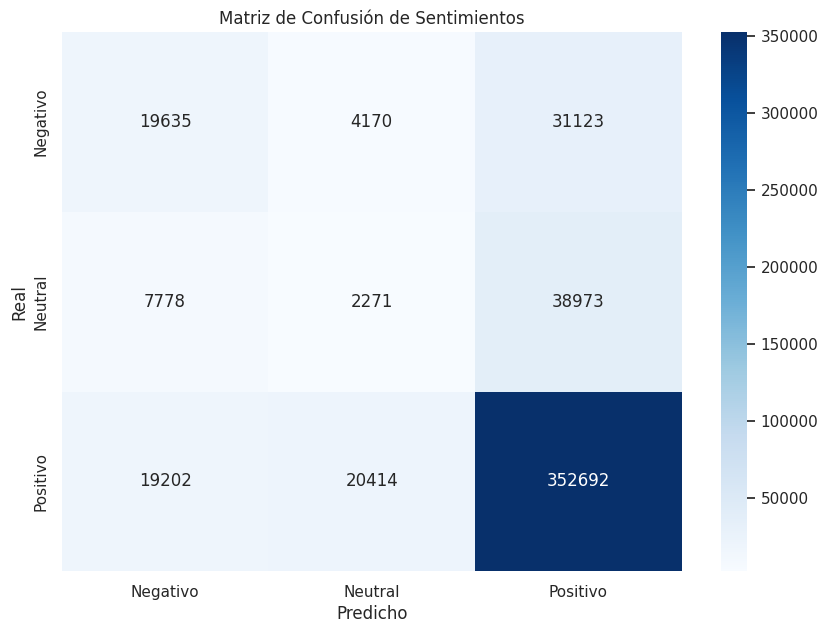

In [18]:

from sklearn.metrics import confusion_matrix, classification_report


# Crear etiquetas reales basadas en la columna 'overall'
df_limpio['etiqueta_real'] = df_limpio['overall'].apply(lambda x: 'Positivo' if x > 3 else ('Negativo' if x < 3 else 'Neutral'))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(df_limpio['etiqueta_real'], df_limpio['sentimiento'], labels=['Negativo', 'Neutral', 'Positivo'])

# Mostrar el reporte de clasificación
print(classification_report(df_limpio['etiqueta_real'], df_limpio['sentimiento']))

# Crear un DataFrame de la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negativo', 'Neutral', 'Positivo'], columns=['Negativo', 'Neutral', 'Positivo'])

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión de Sentimientos')
plt.show()


### EN LA CELDA ANTERIOR ESTAN LAS METRICAS DEL MODELO DE **VADER**

<ipython-input-13-56687c163360>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=df_limpio, palette='viridis')


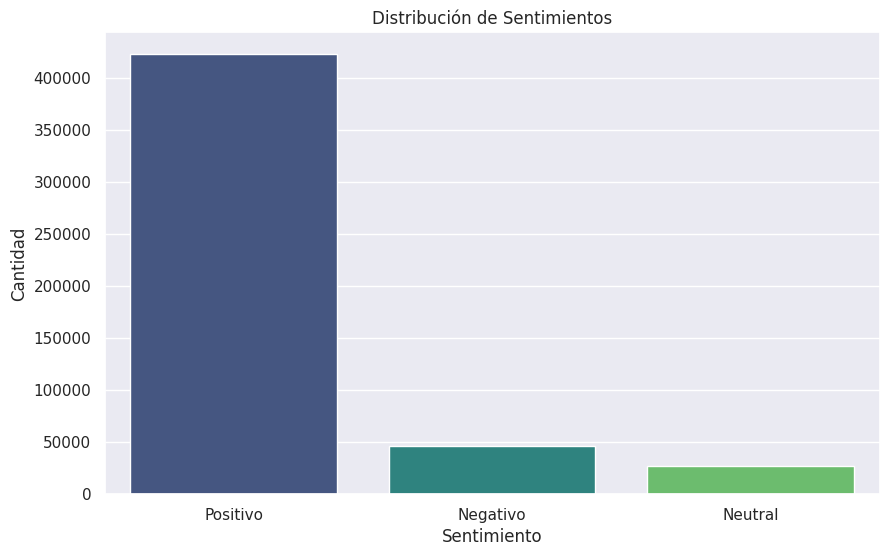

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt
# Configurar el estilo de las gráficas
sns.set(style="darkgrid")

# Distribución de sentimientos
plt.figure(figsize=(10, 6))
sns.countplot(x='sentimiento', data=df_limpio, palette='viridis')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()



<ipython-input-15-a7a042ea9895>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall', y='sentimiento', data=df_limpio, palette='viridis')


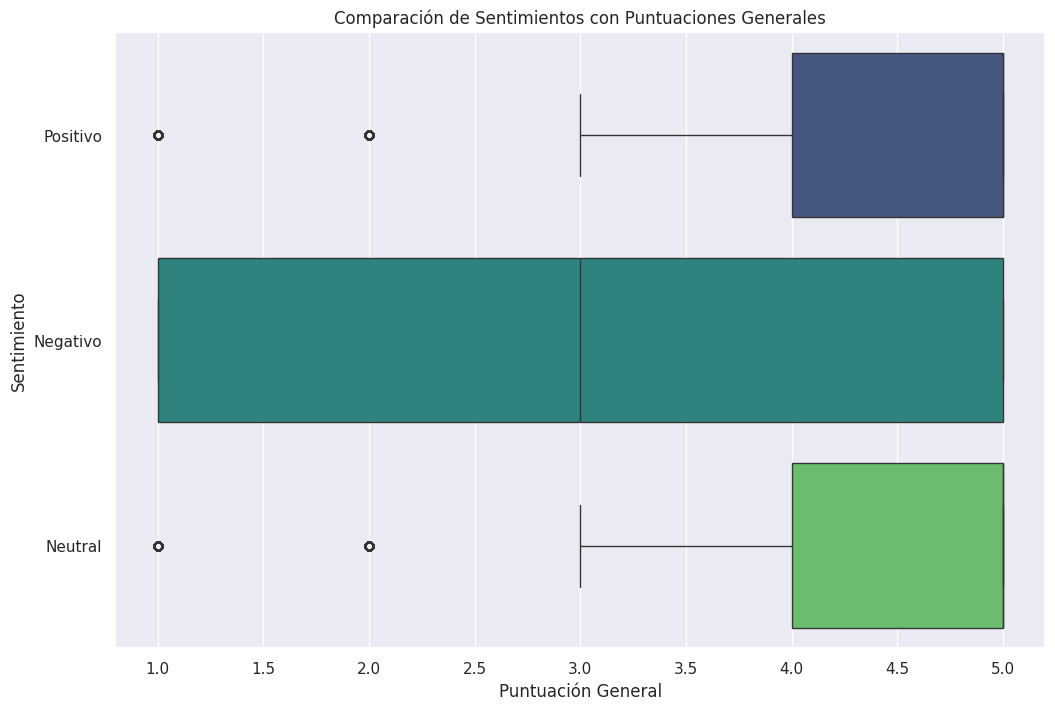

In [15]:
# Comparación de sentimientos con puntuaciones
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='sentimiento', data=df_limpio, palette='viridis')
plt.title('Comparación de Sentimientos con Puntuaciones Generales')
plt.xlabel('Puntuación General')
plt.ylabel('Sentimiento')
plt.show()


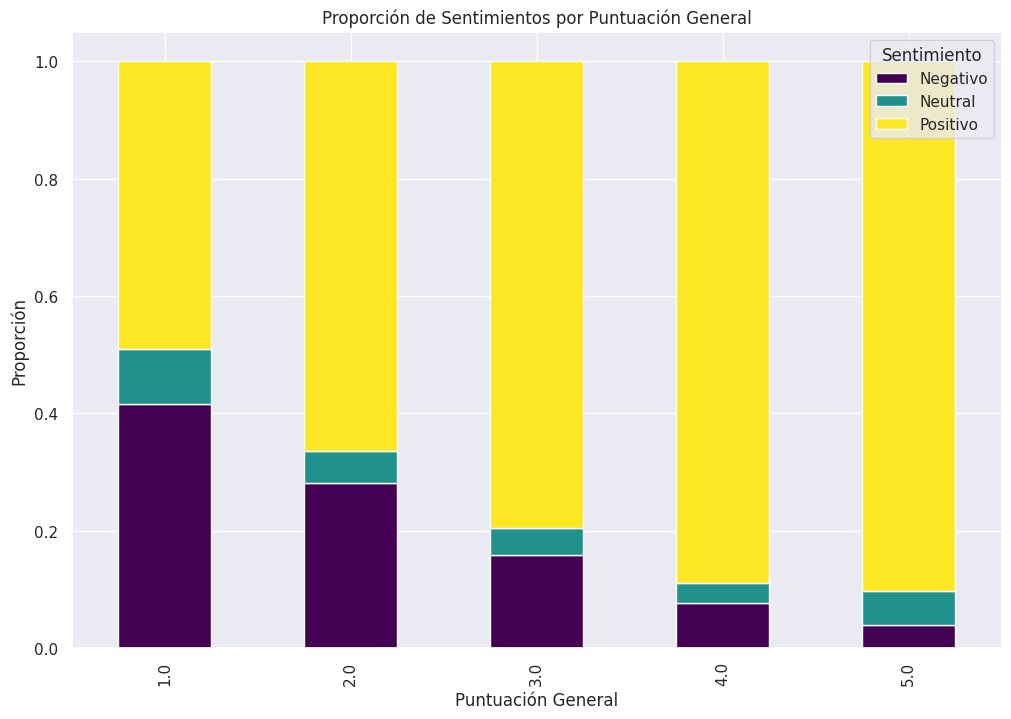

In [17]:
# Proporción de sentimientos por puntuación general
sentimiento_counts = df_limpio.groupby(['overall', 'sentimiento']).size().unstack().fillna(0)
sentimiento_proporciones = sentimiento_counts.div(sentimiento_counts.sum(axis=1), axis=0)

# Gráfica de barras apiladas
sentimiento_proporciones.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Proporción de Sentimientos por Puntuación General')
plt.xlabel('Puntuación General')
plt.ylabel('Proporción')
plt.legend(title='Sentimiento')
plt.show()


Usando el Modelo personalizado

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

def get_sentiment_label(rating):
    if rating >= 4:
        return 'Positivo'
    elif rating <= 2:
        return 'Negativo'
    else:
        return 'Neutral'

df_limpio['sentimiento'] = df_limpio['overall'].apply(get_sentiment_label)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(df_limpio['cleaned_reviewText'], df_limpio['sentimiento'], test_size=0.2, random_state=42)

# Vectorización de textos
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Entrenamiento del modelo
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Predicciones
y_pred = model.predict(X_test_vectorized)

# Evaluación del modelo
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Aplicar modelo al DataFrame original
df_limpio['predicted_sentiment'] = model.predict(vectorizer.transform(df_limpio['cleaned_reviewText']))

# Mostrar algunas filas del DataFrame con el sentimiento
print(df_limpio[['cleaned_reviewText', 'sentimiento', 'predicted_sentiment']].head())


Accuracy: 0.8165880788296458
              precision    recall  f1-score   support

    Negativo       0.60      0.50      0.54     11267
     Neutral       0.35      0.20      0.25      9849
    Positivo       0.87      0.94      0.91     78136

    accuracy                           0.82     99252
   macro avg       0.61      0.55      0.57     99252
weighted avg       0.79      0.82      0.80     99252

                                  cleaned_reviewText sentimiento  \
0                           game bit hard hang great    Positivo   
1  play alright steam bit trouble game steam hard...    Positivo   
2                                            ok game     Neutral   
3  find game bit complicated expect having play 1...    Negativo   
4                        great game love play arrive    Positivo   

  predicted_sentiment  
0            Positivo  
1            Negativo  
2            Positivo  
3            Positivo  
4            Positivo  


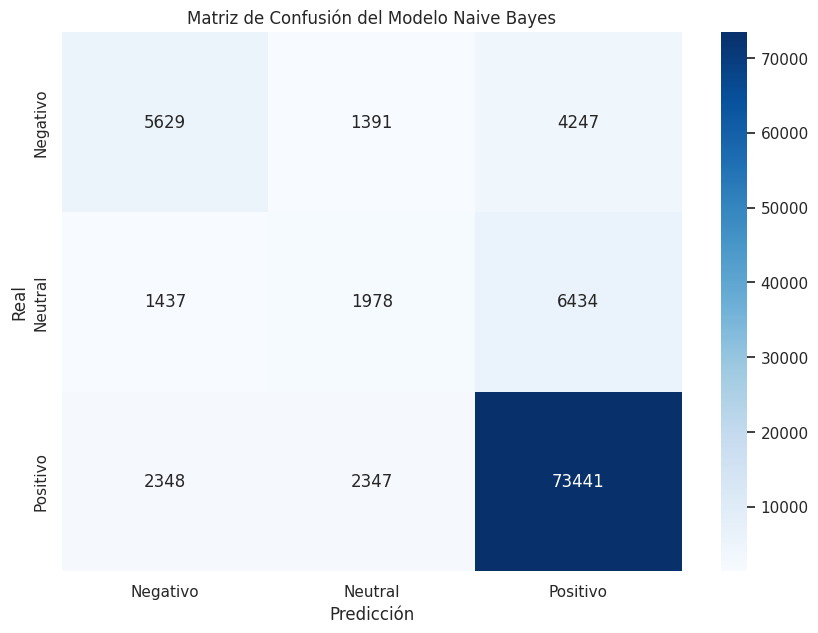

In [20]:


# Crear matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Negativo', 'Neutral', 'Positivo'])

# Crear DataFrame de la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negativo', 'Neutral', 'Positivo'], columns=['Negativo', 'Neutral', 'Positivo'])

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión del Modelo Naive Bayes')
plt.show()

# Aplicar modelo al DataFrame original
df_limpio['predicted_sentiment'] = model.predict(vectorizer.transform(df_limpio['cleaned_reviewText']))


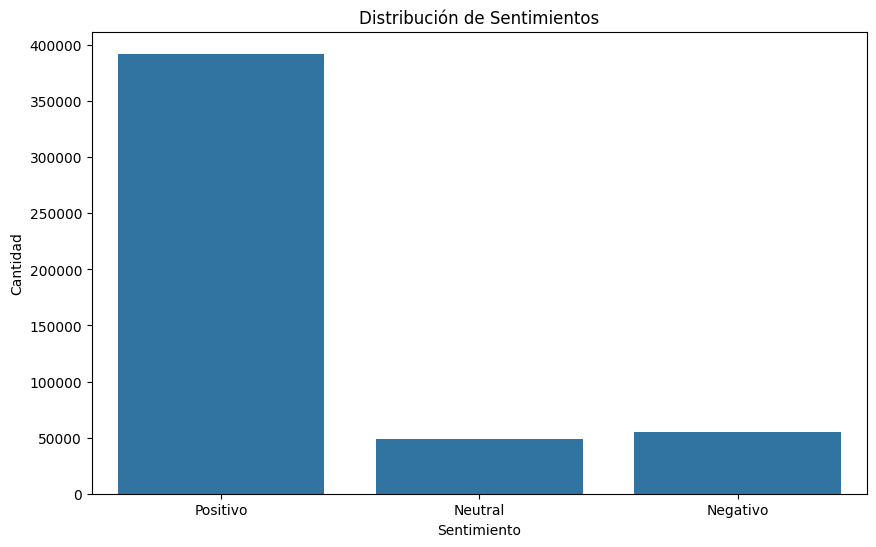

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Distribución de sentimientos
plt.figure(figsize=(10, 6))
sns.countplot(x='sentimiento', data=df_limpio)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()


<ipython-input-13-a7a042ea9895>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall', y='sentimiento', data=df_limpio, palette='viridis')


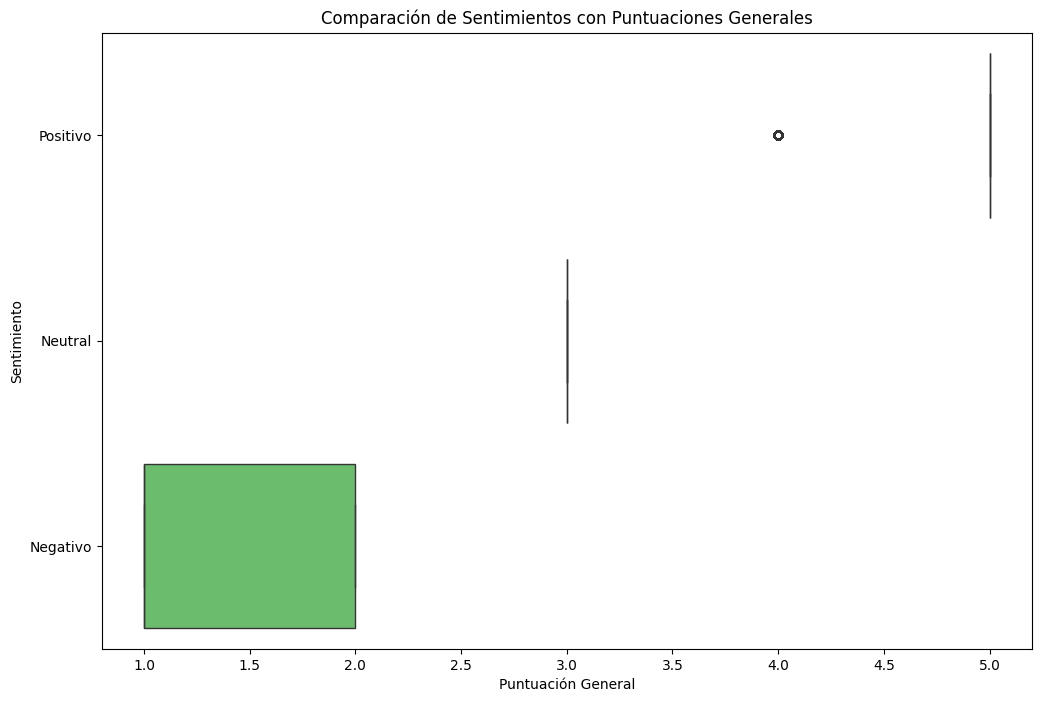

In [ ]:
# Comparación de sentimientos con puntuaciones
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='sentimiento', data=df_limpio, palette='viridis')
plt.title('Comparación de Sentimientos con Puntuaciones Generales')
plt.xlabel('Puntuación General')
plt.ylabel('Sentimiento')
plt.show()


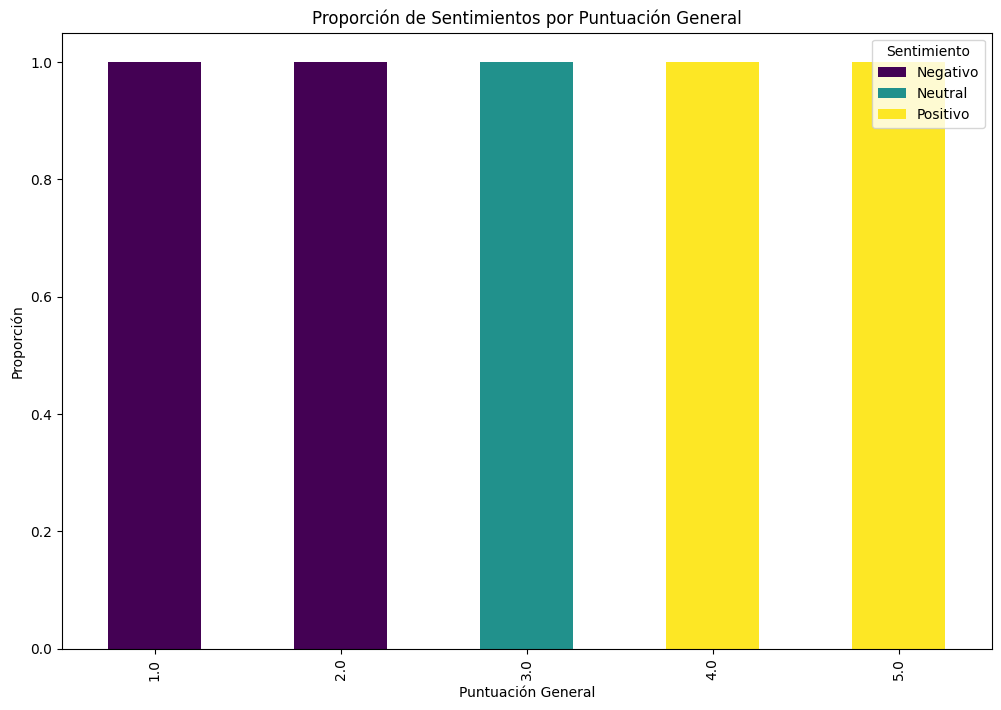

In [ ]:
# Proporción de sentimientos por puntuación general
sentimiento_counts = df_limpio.groupby(['overall', 'sentimiento']).size().unstack().fillna(0)
sentimiento_proporciones = sentimiento_counts.div(sentimiento_counts.sum(axis=1), axis=0)

# Gráfica de barras apiladas
sentimiento_proporciones.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Proporción de Sentimientos por Puntuación General')
plt.xlabel('Puntuación General')
plt.ylabel('Proporción')
plt.legend(title='Sentimiento')
plt.show()


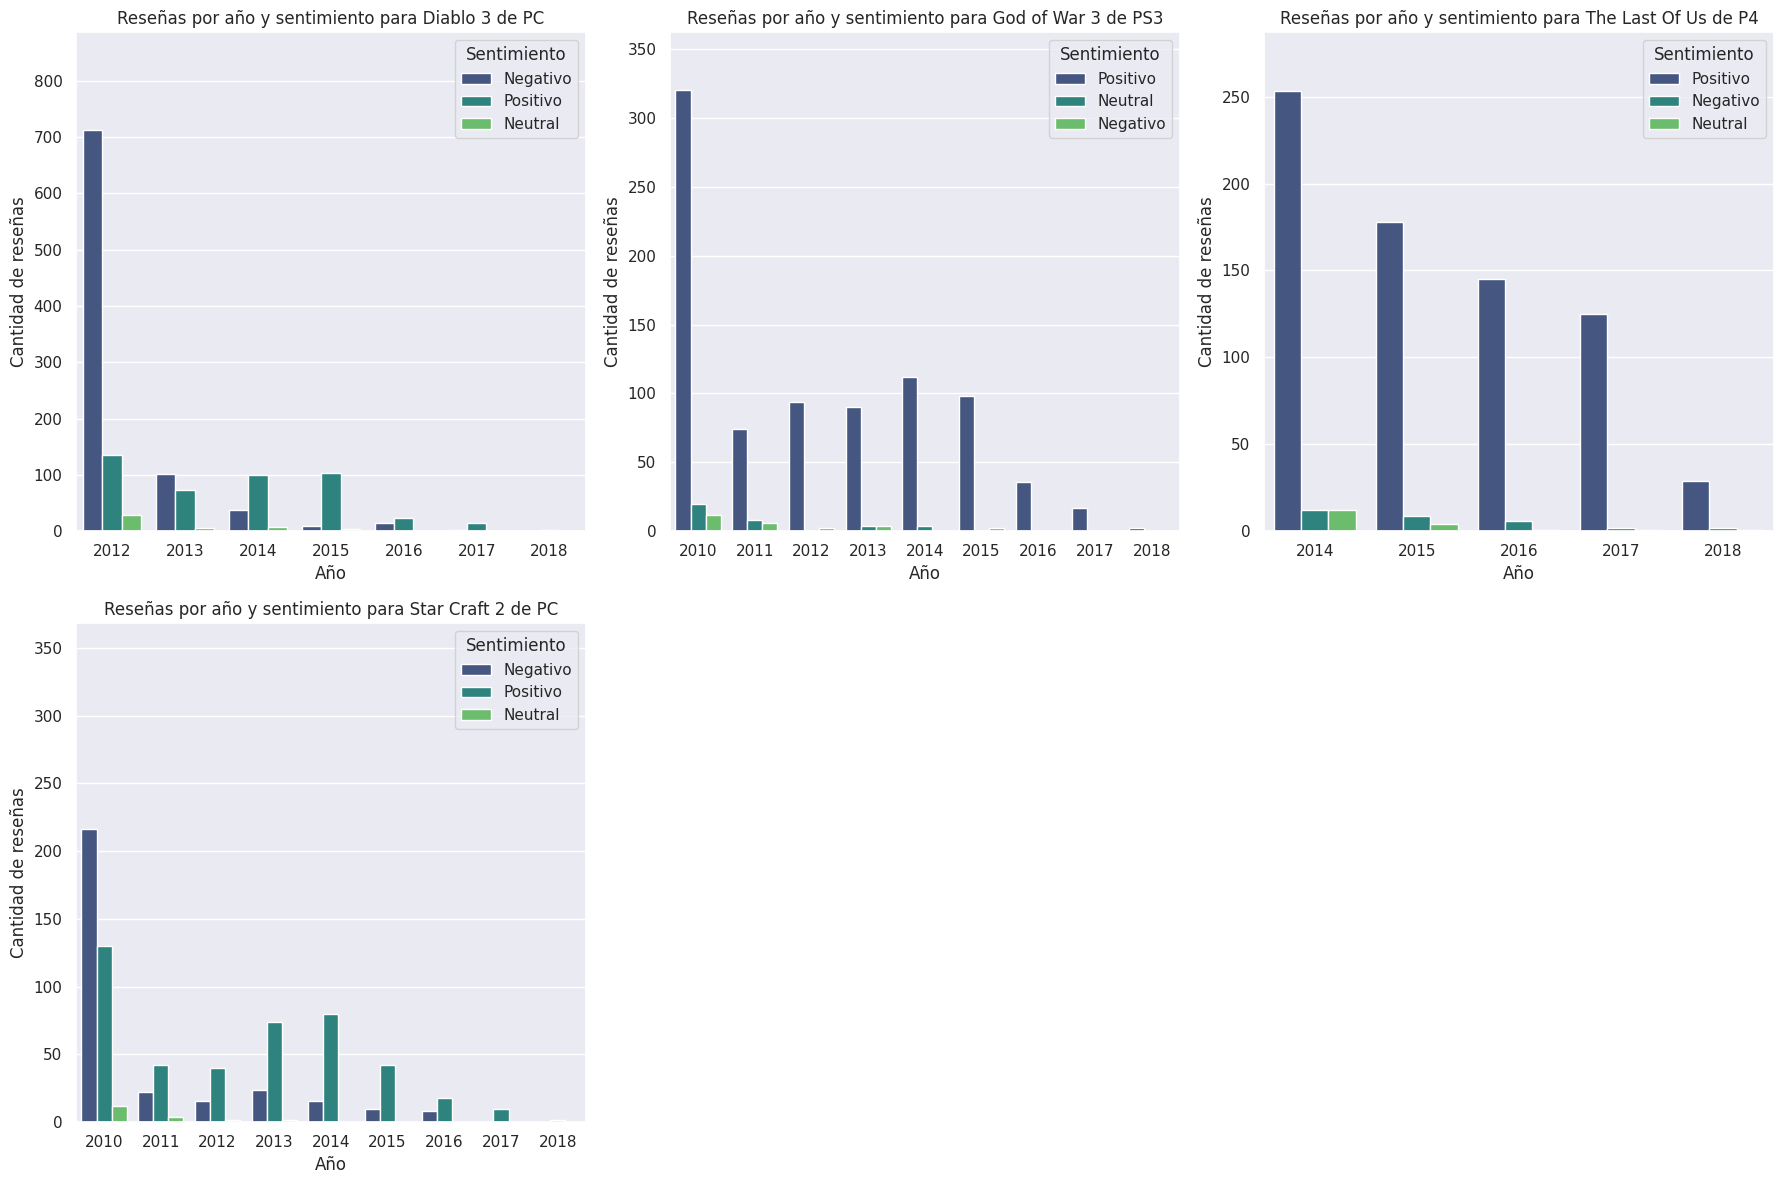

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Identificadores de productos
games_ids = {
    'Diablo 3 de PC': 'B00178630A',
    'God of War 3 de PS3': 'B000ZK9QCS',
    'The Last Of Us de P4': 'B00JK00S0S',
    'Star Craft 2 de PC': 'B000ZKA0J6'
}

# Filtrar reseñas por los identificadores de productos y aplicar análisis de sentimientos
plt.figure(figsize=(18, 12))
for game_name, game_id in games_ids.items():
    game_reviews = df_limpio[df_limpio['asin'] == game_id].copy()

    # Convertir reviewTime a datetime si no está ya en ese formato
    game_reviews['reviewTime'] = pd.to_datetime(game_reviews['reviewTime'])
    game_reviews['year'] = game_reviews['reviewTime'].dt.year

    ax = plt.subplot(2, 3, list(games_ids.keys()).index(game_name) + 1)  # Subplot position
    sns.countplot(data=game_reviews, x='year', hue='predicted_sentiment', palette='viridis')
    plt.title(f'Reseñas por año y sentimiento para {game_name}')
    plt.xlabel('Año')
    plt.ylabel('Cantidad de reseñas')
    plt.legend(title='Sentimiento')

    # Manejo de caso cuando no hay datos para calcular el máximo
    if not game_reviews.empty and not game_reviews['year'].value_counts().empty:
        plt.ylim(0, max(game_reviews['year'].value_counts()) + 10)
    else:
        plt.ylim(0, 10)  # Valor predeterminado si no hay datos disponibles

plt.tight_layout()
plt.show()
